In [238]:
from src.data.protests.sources.acled import load_acled

acled = load_acled()

In [239]:
len(acled)

13224

In [240]:
from src.data.news.sources.mediacloud import newspapers_by_region

acled = acled[acled["admin1"].isin(newspapers_by_region.keys())]
climate_actors = [
    "FFF: Fridays for Future; Students (Germany)",
    "ALG: Uprising of the Last Generation (Germany)",
    "Extinction Rebellion",
    "Ende Gelaende",
]
acled = acled[acled["assoc_actor_1"].isin(climate_actors)]
acled = acled[
    (acled["event_date"] >= "2020-04-01") & (acled["event_date"] < "2022-09-01")
]

<Axes: >

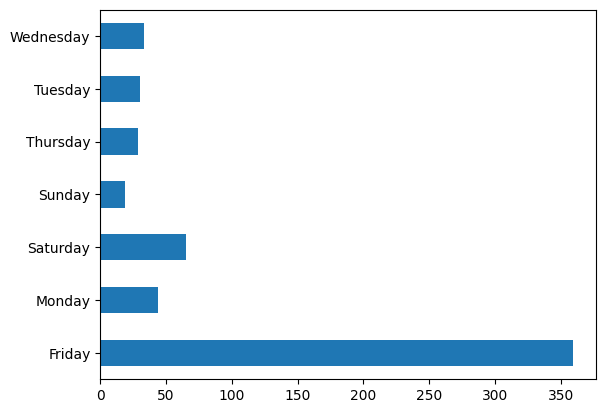

In [241]:
acled["weekday"].value_counts().sort_index().plot.barh()

In [242]:
import matplotlib.pyplot as plt

from src.models.synthetic_region import get_regional_counts_for_protest

dfs = [
    get_regional_counts_for_protest(protest, acled, n_days=7 * 4 * 6)
    for protest in acled.itertuples()
]

In [243]:
dfs[0].sample(10)

,date,count,region,is_protest_region
1155,2022-11-29,0,Sachsen-Anhalt,False
1129,2022-11-03,1,Bremen,False
1171,2022-12-15,7,Brandenburg,False
905,2022-03-24,9,Sachsen,False
1015,2022-07-12,0,Sachsen-Anhalt,False
1167,2022-12-11,0,Rheinland-Pfalz,False
1178,2022-12-22,4,Sachsen,False
962,2022-05-20,21,Niedersachsen,False
1146,2022-11-20,34,Bayern,False
892,2022-03-11,6,Berlin,False


In [244]:
import math

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error


def synthetic_region(df):
    protest_region = df[df["is_protest_region"]]["region"].unique()[0]
    df_ = df.pivot(index="date", columns="region", values="count")
    df_ = df_.reset_index()
    split = math.floor(len(df_) / 2) - 1
    train = df_.iloc[:split]
    test = df_.iloc[split:]
    eval_split = math.floor(len(df_) / 4)
    eval_train = train.iloc[:eval_split]
    eval_test = train.iloc[eval_split:]

    Y_eval_train = eval_train[protest_region]
    X_eval_train = eval_train.drop(columns=[protest_region, "date"])
    Y_eval_test = eval_test[protest_region]
    X_eval_test = eval_test.drop(columns=[protest_region, "date"])
    model = Lasso(fit_intercept=True)
    model.fit(X_eval_train, Y_eval_train)
    Y_eval_pred = model.predict(X_eval_test)
    mse_eval = mean_squared_error(Y_eval_test, Y_eval_pred)

    mean_eval_test = X_eval_test.mean(axis=1)
    mean_eval_test_scaled = (
        mean_eval_test * Y_eval_train.mean() / X_eval_train.mean().mean()
    )
    mse_mean_eval = mean_squared_error(Y_eval_test, mean_eval_test_scaled)

    train = df_.iloc[eval_split:split]
    test = df_.iloc[split : len(df_) - eval_split]
    Y_train = train[protest_region]
    X_train = train.drop(columns=[protest_region, "date"])
    Y_test = test[protest_region]
    X_test = test.drop(columns=[protest_region, "date"])

    model = Lasso(fit_intercept=True)
    model.fit(X_train, Y_train)

    Y_pred = model.predict(X_test)
    mse_test = mean_squared_error(Y_test, Y_pred)

    mean_test = X_test.mean(axis=1)
    mean_test_scaled = mean_test * Y_train.mean() / X_train.mean().mean()
    mse_mean_test = mean_squared_error(Y_test, mean_test_scaled)

    metrics = {
        "mse_eval": mse_eval,
        "mse_mean_eval": mse_mean_eval,
        "mse_test": mse_test,
        "mse_mean_test": mse_mean_test,
        "change_1_week": (Y_pred[:7] / Y_train[:7]).mean(),
        "change_2_weeks": (Y_pred[:14] / Y_train[:14]).mean(),
        "change_4_weeks": (Y_pred[:28] / Y_train[:28]).mean(),
        "change_8_weeks": (Y_pred[:56] / Y_train[:56]).mean(),
    }

    Y_pred_all = model.predict(pd.concat([X_train, X_test]))
    mean_all = pd.concat([X_train, X_test]).mean(axis=1)
    mean_all_scaled = mean_all * Y_train.mean() / X_train.mean().mean()
    df = pd.DataFrame(
        {
            "date": df_["date"].iloc[eval_split : len(df_) - eval_split],
            "real": df_[protest_region].iloc[eval_split : len(df_) - eval_split],
            "mean": mean_all_scaled,
            "synthetic": Y_pred_all,
        }
    )
    return metrics, model, df


metrics_list = []
meta_metrics = []
count_dfs = []
for df in dfs:
    metrics, _, count_df = synthetic_region(df)
    metrics_list.append(metrics)
    meta_metrics.append(
        {
            "mse_vs_mean_eval": (metrics["mse_eval"] / metrics["mse_mean_eval"]),
            "mse_vs_mean_test": (metrics["mse_test"] / metrics["mse_mean_test"]),
            "mse_test_vs_eval": (metrics["mse_test"] / metrics["mse_eval"]),
            "mse_mean_test_vs_eval": (
                metrics["mse_mean_test"] / metrics["mse_mean_eval"]
            ),
        }
    )
    count_dfs.append(count_df)
metrics = pd.DataFrame(metrics_list)
meta_metrics = pd.DataFrame(meta_metrics)

In [245]:
import numpy as np

# remove rows where any metric is infinite
metrics = metrics.replace([np.inf, -np.inf], np.nan).dropna()

In [246]:
change_metrics = metrics[
    ["change_1_week", "change_2_weeks", "change_4_weeks", "change_8_weeks"]
]
change_metrics.apply(np.log2).describe()

,change_1_week,change_2_weeks,change_4_weeks,change_8_weeks
count,252.000000,252.000000,252.000000,252.000000
mean,0.736850,0.706581,0.738411,0.894472
std,1.358384,1.191703,1.051083,0.854307
min,-6.501396,-4.977416,-2.879589,-1.702217
25%,0.282393,0.186433,0.209116,0.441661
50%,0.797384,0.735545,0.624824,0.767704
75%,1.420467,1.252243,1.533015,1.646803
max,3.563707,3.131590,2.665116,2.507587


In [247]:
change_metrics.mean()

change_1_week     2.353192
change_2_weeks    2.180348
change_4_weeks    2.156484
change_8_weeks    2.195261
dtype: float64

In [248]:
change_metrics.std()

change_1_week     2.100045
change_2_weeks    1.701246
change_4_weeks    1.613637
change_8_weeks    1.281143
dtype: float64

In [249]:
change_metrics.apply(np.log2).mean().apply(np.exp2)

change_1_week     1.666533
change_2_weeks    1.631932
change_4_weeks    1.668337
change_8_weeks    1.858929
dtype: float64

In [250]:
change_metrics.apply(np.log2).std().apply(np.exp2)

change_1_week     2.563977
change_2_weeks    2.284221
change_4_weeks    2.072085
change_8_weeks    1.807890
dtype: float64

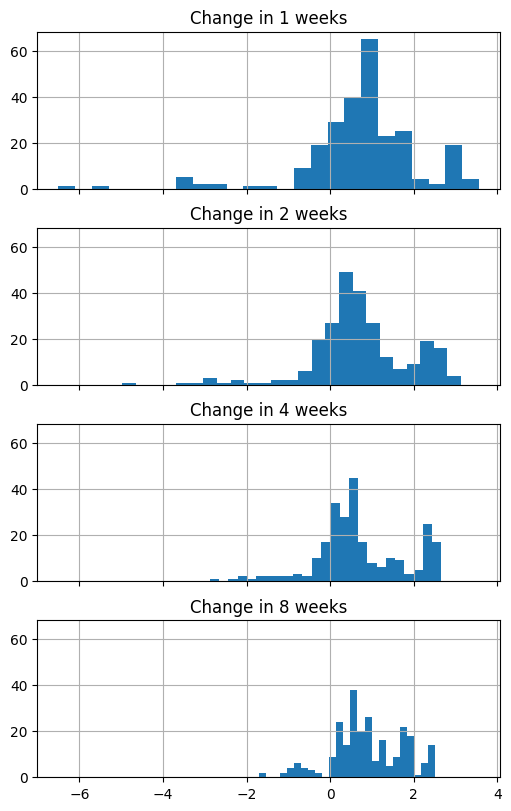

In [251]:
import matplotlib.pyplot as plt
import numpy as np

# plenty space between subplots
fig, axs = plt.subplots(
    4, 1, figsize=(5, 8), sharex=True, sharey=True, constrained_layout=True
)
metrics["change_1_week"].apply(np.log2).hist(bins=25, ax=axs[0])
metrics["change_2_weeks"].apply(np.log2).hist(bins=25, ax=axs[1])
metrics["change_4_weeks"].apply(np.log2).hist(bins=25, ax=axs[2])
metrics["change_8_weeks"].apply(np.log2).hist(bins=25, ax=axs[3])
for i, ax in enumerate(axs):
    ax.set_title(f"Change in {2**i} weeks")
plt.show()

In [252]:
meta_metrics.describe()

,mse_vs_mean_eval,mse_vs_mean_test,mse_test_vs_eval,mse_mean_test_vs_eval
count,579.000000,579.000000,579.000000,579.000000
mean,0.869948,0.865471,1.668791,1.596107
std,0.294391,0.244349,1.055540,0.881514
min,0.264612,0.249371,0.191472,0.123174
25%,0.636445,0.735674,0.864443,0.952985
50%,0.876903,0.848024,1.441443,1.362546
75%,1.039788,1.006359,2.129879,2.169479
max,2.177223,2.206976,7.213103,5.387756


57


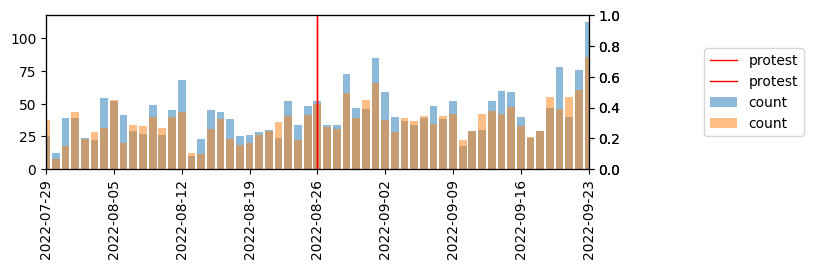

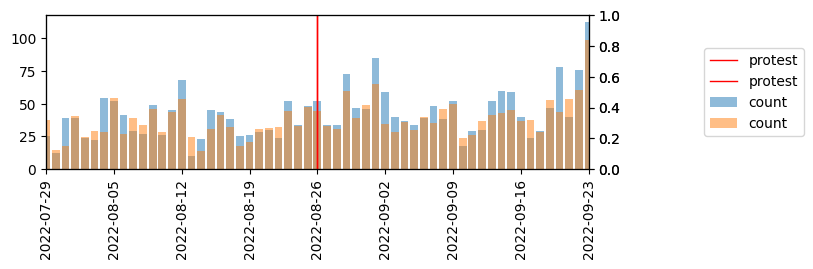

In [253]:
from src.data.news.visual import plot_coverage_sequence

df = count_dfs[0].iloc[8 * 7 : -8 * 7]
print(len(df))
fig, ax = plt.subplots(figsize=(7, 2))
plot_coverage_sequence(df.rename(columns={"real": "count"}), title="", ax=ax, alpha=0.5)
plot_coverage_sequence(df.rename(columns={"mean": "count"}), title="", ax=ax, alpha=0.5)
plt.show()
fig, ax = plt.subplots(figsize=(7, 2))
plot_coverage_sequence(df.rename(columns={"real": "count"}), title="", ax=ax, alpha=0.5)
plot_coverage_sequence(
    df.rename(columns={"synthetic": "count"}), title="", ax=ax, alpha=0.5
)
plt.show()

In [254]:
df_ = pd.DataFrame()
for df in dfs:
    metrics, model, df = synthetic_region(df)
    # set the dates relative to the protest
    df["date"] = df.index - df.index.min()
    df_ = pd.concat([df_, df])

In [255]:
df__ = df_.groupby("date").sum().reset_index()
df__.head()

,date,real,mean,synthetic
0,0,9679,8495.787708,9551.370081
1,1,6765,6851.546985,8273.345538
2,2,7583,7674.926052,8826.665892
3,3,9454,8011.663349,9378.004445
4,4,10748,10162.305293,10308.502588


In [256]:
%reload_ext autoreload
%autoreload complete

from src.data.news.visual import plot_coverage_sequence

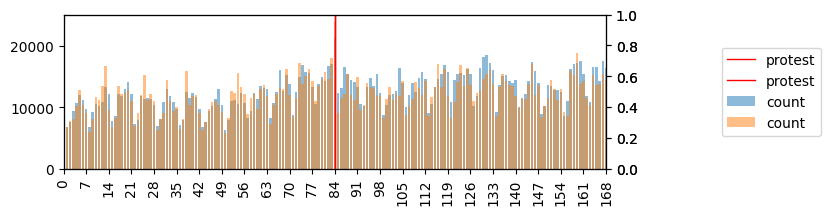

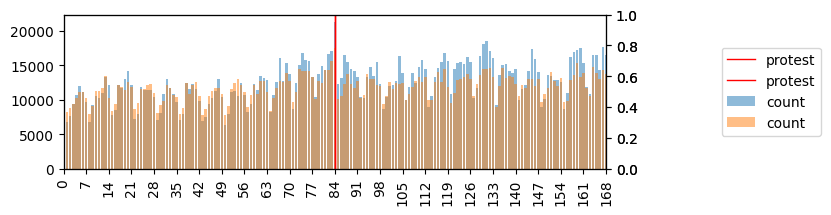

In [257]:
fig, ax = plt.subplots(figsize=(7, 2))
plot_coverage_sequence(
    df__.rename(columns={"real": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plot_coverage_sequence(
    df__.rename(columns={"mean": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plt.show()
fig, ax = plt.subplots(figsize=(7, 2))
plot_coverage_sequence(
    df__.rename(columns={"real": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plot_coverage_sequence(
    df__.rename(columns={"synthetic": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plt.show()

In [258]:
# limit df__ to 4 weeks before and after protest
df__ = df__.iloc[8 * 7 : -8 * 7]

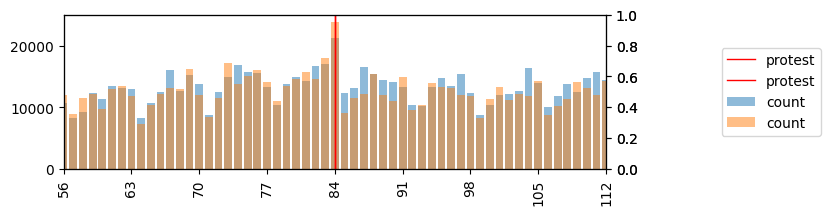

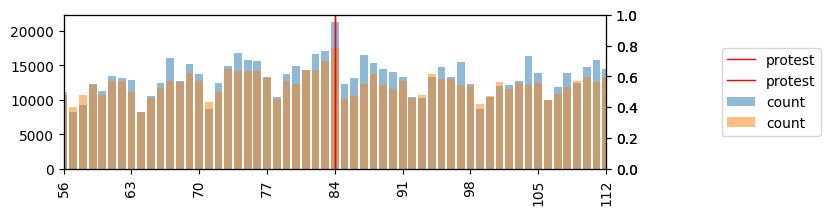

In [259]:
fig, ax = plt.subplots(figsize=(7, 2))
plot_coverage_sequence(
    df__.rename(columns={"real": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plot_coverage_sequence(
    df__.rename(columns={"mean": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plt.show()
fig, ax = plt.subplots(figsize=(7, 2))
plot_coverage_sequence(
    df__.rename(columns={"real": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plot_coverage_sequence(
    df__.rename(columns={"synthetic": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plt.show()

In [260]:
acled.head()

,event_date,sub_event_type,assoc_actor_1,admin1,location,notes,region_code,size,weekday
1625,2022-08-26,Peaceful protest,FFF: Fridays for Future; Students (Germany),Nordrhein-Westfalen,Bochum,"On 26 August 2022, around 100 people, includin...",NW,100.0,Friday
1678,2022-08-13,Protest with intervention,Extinction Rebellion,Hamburg,Hamburg - Wilhelmsburg,"On 13 August 2022, around 30 people, including...",HH,30.0,Saturday
1682,2022-08-13,Peaceful protest,Ende Gelaende,Hamburg,Hamburg,"On 13 August 2022, around 2,000 people, includ...",HH,1.0,Saturday
1687,2022-08-12,Peaceful protest,Ende Gelaende,Niedersachsen,Wilhelmshaven,"On 12 August 2022, between 200 (according to t...",NI,300.0,Friday
1688,2022-08-12,Peaceful protest,Ende Gelaende,Niedersachsen,Hooksiel,"On 12 August 2022, between 200 (according to t...",NI,300.0,Friday


In [261]:
random_events = []
for _ in range(500):
    random_date = pd.to_datetime(
        np.random.randint(0, 3 * 365 - 8 * 31, 1), unit="D", origin="2020-04-01"
    ).item()
    # generate random region
    random_region = np.random.choice(acled["admin1"].unique())
    random_events.append(
        {
            "event_date": random_date,
            "admin1": random_region,
        }
    )
random_events = pd.DataFrame(random_events)
random_events.head()

,event_date,admin1
0,2022-04-21,Nordrhein-Westfalen
1,2021-10-14,Hamburg
2,2022-07-18,Sachsen
3,2022-05-16,Hamburg
4,2020-07-03,Bayern


In [262]:
dfs = [
    get_regional_counts_for_protest(protest, random_events, n_days=7 * 4 * 6)
    for protest in random_events.itertuples()
]

In [263]:
metrics_list = []
meta_metrics = []
count_dfs = []
for df in dfs:
    metrics, _, count_df = synthetic_region(df)
    metrics_list.append(metrics)
    meta_metrics.append(
        {
            "mse_vs_mean_eval": (metrics["mse_eval"] / metrics["mse_mean_eval"]),
            "mse_vs_mean_test": (metrics["mse_test"] / metrics["mse_mean_test"]),
            "mse_test_vs_eval": (metrics["mse_test"] / metrics["mse_eval"]),
            "mse_mean_test_vs_eval": (
                metrics["mse_mean_test"] / metrics["mse_mean_eval"]
            ),
        }
    )
    count_dfs.append(count_df)
metrics = pd.DataFrame(metrics_list)
meta_metrics = pd.DataFrame(meta_metrics)

In [264]:
df_ = pd.DataFrame()
for df in dfs:
    metrics, model, df = synthetic_region(df)
    # set the dates relative to the protest
    df["date"] = df.index - df.index.min()
    df_ = pd.concat([df_, df])
df__ = df_.groupby("date").sum().reset_index()
df__.head()
df__ = df__.iloc[4 * 7 : -4 * 7]

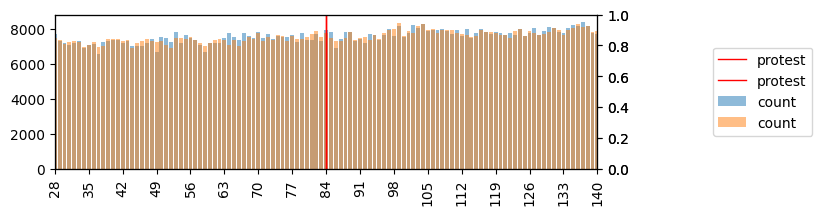

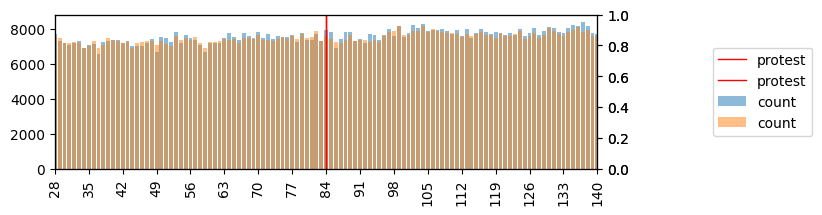

In [265]:
fig, ax = plt.subplots(figsize=(7, 2))
plot_coverage_sequence(
    df__.rename(columns={"real": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plot_coverage_sequence(
    df__.rename(columns={"mean": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plt.show()
fig, ax = plt.subplots(figsize=(7, 2))
plot_coverage_sequence(
    df__.rename(columns={"real": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plot_coverage_sequence(
    df__.rename(columns={"synthetic": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plt.show()

In [266]:
random_fridays = []
for _ in range(500):
    # generate all fridays between 2020-04-01 and 2022-12-31
    fridays = pd.date_range("2020-04-01", "2022-08-31", freq="W-FRI")
    random_friday = np.random.choice(fridays)
    # generate random region
    random_region = np.random.choice(acled["admin1"].unique())
    random_fridays.append(
        {
            "event_date": random_friday,
            "admin1": random_region,
        }
    )
random_fridays = pd.DataFrame(random_fridays)
dfs = [
    get_regional_counts_for_protest(protest, random_fridays, n_days=7 * 4 * 6)
    for protest in random_fridays.itertuples()
]
metrics_list = []
meta_metrics = []
count_dfs = []
for df in dfs:
    metrics, _, count_df = synthetic_region(df)
    metrics_list.append(metrics)
    meta_metrics.append(
        {
            "mse_vs_mean_eval": (metrics["mse_eval"] / metrics["mse_mean_eval"]),
            "mse_vs_mean_test": (metrics["mse_test"] / metrics["mse_mean_test"]),
            "mse_test_vs_eval": (metrics["mse_test"] / metrics["mse_eval"]),
            "mse_mean_test_vs_eval": (
                metrics["mse_mean_test"] / metrics["mse_mean_eval"]
            ),
        }
    )
    count_dfs.append(count_df)
metrics = pd.DataFrame(metrics_list)
meta_metrics = pd.DataFrame(meta_metrics)
df_ = pd.DataFrame()
for df in dfs:
    metrics, model, df = synthetic_region(df)
    # set the dates relative to the protest
    df["date"] = df.index - df.index.min()
    df_ = pd.concat([df_, df])
df__ = df_.groupby("date").sum().reset_index()
df__.head()
df__ = df__.iloc[4 * 7 : -4 * 7]

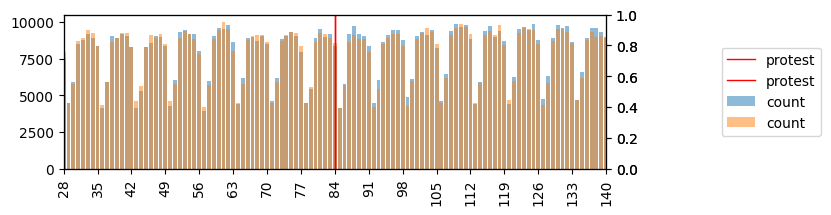

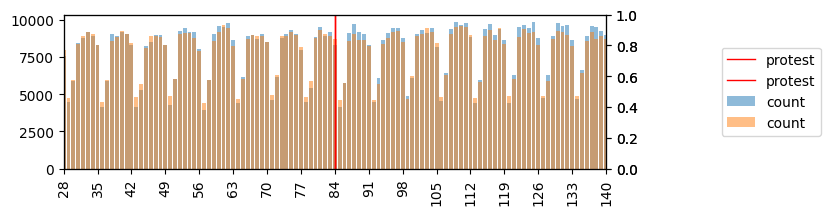

In [267]:
fig, ax = plt.subplots(figsize=(7, 2))
plot_coverage_sequence(
    df__.rename(columns={"real": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plot_coverage_sequence(
    df__.rename(columns={"mean": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plt.show()
fig, ax = plt.subplots(figsize=(7, 2))
plot_coverage_sequence(
    df__.rename(columns={"real": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plot_coverage_sequence(
    df__.rename(columns={"synthetic": "count"}),
    title="",
    ax=ax,
    alpha=0.5,
    relative_dates=True,
)
plt.show()